## Analysing the peak results from a hot-deformation experiment

This notebook is used to extract peak results calculated from Continuous-Peak-Fit, to calculate the elastic strain partitioning of two phase materials during hot-deformation.

In [201]:
import matplotlib.pyplot as plt

import continuous_peak_fit_analysis_functions as analysis
import continuous_peak_fit_deformation_functions as deformation
import continuous_peak_fit_sxrd_functions as sxrd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
pwd

'/mnt/eps01-rds/Fonseca-Lightform/mbcx9cd4/SXRD_analysis_packages/continuous-peak-fit-analysis/notebooks'

## Load YAML file

The file paths and user inputs for the analysis of the Diamond 2017, 2021, 2022, and DESY 2020, 2021 experiments are included in the `yaml` configuration files, to record the inputs of the analysis.

In this case, there are 2x `yaml` files required to analyse the data. 

The **first** yaml file contains information about the .fit files, which can also be used to directly extract the intensities for calculating crystallographic texture.

The **second** yaml file contains additional information about the deformation setup.

The information in the `yaml` files can be accessed like this...

In [203]:
# to load the Diamond 2017, Diamond 2021, DESY 2020 or DESY 2021 experiment analysis
config_path_texture = "yaml/texture/diamond/config_diamond_2022_022.yaml"
config_path_deformation = "yaml/deformation/diamond/config_diamond_2022_022.yaml"

config_texture = analysis.get_config(config_path_texture)
config_deformation = analysis.get_config(config_path_deformation)

## Extracting the single peak profile data from fit files

The single peak profile data (such as the peak position, peak intensity, half-width and pseudo-Voigt weighting) obtained from the Fourier peak analysis in Continuous-Peak-Fit can be extracted from the .fit files using the `read_fit_results` function.

The user inputs required to extract the intensity data are taken directly from the **first** `yaml` configuration file, using the `extract_intensity_input` function. The user inputs include;

- Input and output file paths
- A list of lattice plane peak labels
- Azimuthal data resolution
- Image numbers

*Note, `image_numbers` is returned as retaining information about the different analysis blocks, which is useful to see each stage of the data load, but `image_numbers_sorted` is a single list of all the image_numbers, which is useful for plotting the data.*

In [204]:
experiment_number, input_fit_path, peak_label, data_resolution, \
image_numbers, image_numbers_sorted = deformation.extract_analysis_input(config_path_texture)

The experiment number is:
22

The input path to the fit file is:
../../../SXRD_analysis/diamond_2022/{experiment_number:03d}_Ti64_Sheet_Longitudinal_RT-Deform_1Ns-1/fourier-peak-analysis/{image_number:05d}.fit

The peak labels for the peaks that are being used are:
['10-10', '0002', '110', '10-11', '10-12', '200', '11-20', '10-13', '20-20', '11-22', '20-21', '0004', '220', '20-22', '10-14', '310', '20-23']

The peak labels for the peaks that are NOT being used are:
{'10-15', '21-31', '211', '21-32', '21-33', '20-24', '321', '222', '11-24', '30-31', '21-30', '30-30'}

The resolution of the data is: 1 degree

The start numbers are: 
[1]
The end numbers are: 
[2618]
The steps are: 
[1]



In [205]:
peak_position, peak_intensity, peak_halfwidth, peak_PV_weight = analysis.read_fit_results(experiment_number, 
                                                                input_fit_path, peak_label, data_resolution, 
                                                                image_numbers)

  0%|          | 0/2618 [00:00<?, ?it/s]

To make sense of the data and look at the behaviour over time, it makes sense to restructure it. We do this by writing the peak results to new arrays. This will then allow us to plot the behaviour of single lattice plane peaks over time.

In [206]:
peak_position_time, peak_intensity_time, \
peak_halfwidth_time, peak_PV_weight_time \
= deformation.restructure_fit_results(image_numbers, peak_label, data_resolution, 
                                      peak_position, peak_intensity, peak_halfwidth, peak_PV_weight)

The new arrays are structured as nested dictionaries, and the data can be accessed by first defining the lattice plane, followed by the azimuthal angle. For example, using this command:

`print(peak_position_time["10-10"][359])`

the position of the {10-10} lattice plane at an azimuthal angle of ${359^\circ}$ is recorded for each of the diffraction pattern image numbers.

## Plot commands

The following plot commands will be used for subsequent plots.

In [207]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('legend',fontsize=20)
plt.rc('axes',linewidth=2)
plt.rc('xtick.major',width=2,size=10)
plt.rc('xtick.minor', width=2, size=5)
plt.rc('ytick.major',width=2,size=10)
plt.rc('ytick.minor',width=2,size=5)

## Load and Synchronise the thermomechanical data

The thermomechanical test data must be loaded and correctly callibrated to the corresponding synchrotron diffraction pattern image number, to make sense of the effect of hot-deformation on the lattice plane peak changes observed in the synchrotron data.

The parameters for the thermomechanical equipment can be loaded from the **second** yaml file. 

These inputs also include some information about the synchrotron data, such as the acquisition frequency, so that the thermomechanical test data can be adjusted to the correct frequency. 

*Note, if this is the first time loading the data then it is possible to leave out the `start_deformation` and `end_deformation` image numbers in the yaml file, and instead use some initial guesses for `start_deformation_initial` and `end_deformation_initial` which you know will approximately cover the entire deformation region. Then, when you have fully checked the data you can go back and rerun this analysis with the correct definition for the start and end image numbers.*

In [208]:
thermomechanical_equipment, thermomechanical_file_path, start_deformation, \
end_deformation, number_of_frames, acquisition_frequency_sxrd, \
minimum_stress, deform_sequence, filter_equipment, output_file_path \
= deformation.extract_thermomechanical_input(config_path_deformation)

The thermomechanical equipment used for the experiment is:
ETMT

The input path for the thermomechanical data is:
../../../SXRD_analysis/diamond_2022/022_Ti64_Sheet_Longitudinal_RT-Deform_1Ns-1/ETMT-output/ETMT_output_022.txt

The start of deformation is number:
20

The end of deformation is number:
2571

The number of frames has been calculated as:
2551

The acquisition frequency of the SXRD pattern images during deformation (in Hz) is:
1.3333625558445528

The minimum stress to detect the start of deformation (in MPa) is:
0

The sequence length to detect the start of deformation is:
1

A median filter is being applied to the equipment data, with a value of:
1

The output file path for saving the plots in the notebook is:
../../../SXRD_results/diamond_2022/experiment_{experiment_number:03d}/fourier-peak-analysis-deformation



The next cell uses the `plot_thermomechanical_data` command to calculate the true stress-strain behaviour measured on the thermomechanical equipment, which is slightly adjusted to match the acquisition frequency of the synchrotron diffraction pattern images.

There are currently two types of data that can be loaded:

1. Instron Electro-thermal mechanical tester (ETMT)
2. DIL 805 A/D/T Compression Dilatometer (Dilatometer)

In both cases the data has been reduced to only cover the hot-deformation regime.

For data from the **ETMT**, a separate notebook [sxrd-thermomechanical-test-analysis](https://github.com/LightForm-group/sxrd-thermomechanical-test-analysis) is first needed to calculate the true stress versus true strain behaviour, which is based on a resistance method to calculate the plastic strain. This creates a text file with the converted true stress and true strain, along with other measured parameters such as temperature. This ETMT data has already been reduced, using the notebook, to start at the point of applied load.

For data from the **Dilatometer**, the true stress and true strain data is included in an ascii text file, which can be saved using the accompanying Dilatometer software. In the case of the Dilatometer, the deformation does not start when the deformation file begins recording, and so a stress signal (typically > 1 MPa for more than 4 points) is used to signal the start of deformation. The data is recorded at such a high acquisition frequency that we can expect this corresponds very well with the lattice strain observed from the synchrotron diffraction patterns.

The `plot_thermomechanical_data` function in the `deformation` functions returns arrays of the true stress and true strain at the adjusted acquisition frequency of the recorded diffraction pattern images.

Loading ETMT data.

Warning! Using Applied Stress as True Stress. Only valid for low strains. Alter script [here] to use True Stress from Resistance Method.

The acquisition frequency of the ETMT data is: 100.00052160215317  Hz

The ratio of ETMT-to-SXRD acquisition is: 74.88

The deformation begins at array index: 0

Deform Frames:  191719
The deformation ends at array index: 191018

The strain has been shifted by an amount: nan  to start at zero

ETMT unfiltered true stress versus data number:


/mnt/eps01-rds/Fonseca-Lightform/mbcx9cd4/SXRD_analysis_packages/continuous-peak-fit-analysis/venv/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/mnt/eps01-rds/Fonseca-Lightform/mbcx9cd4/SXRD_analysis_packages/continuous-peak-fit-analysis/venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


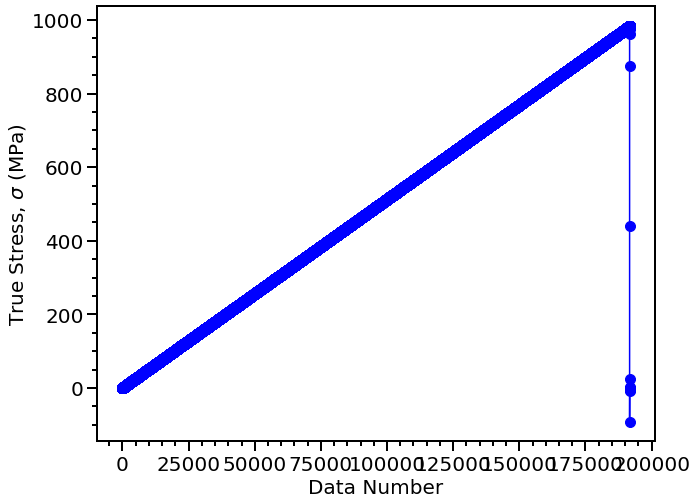

ETMT true stress-strain at thermomechanical acquisition frequency:


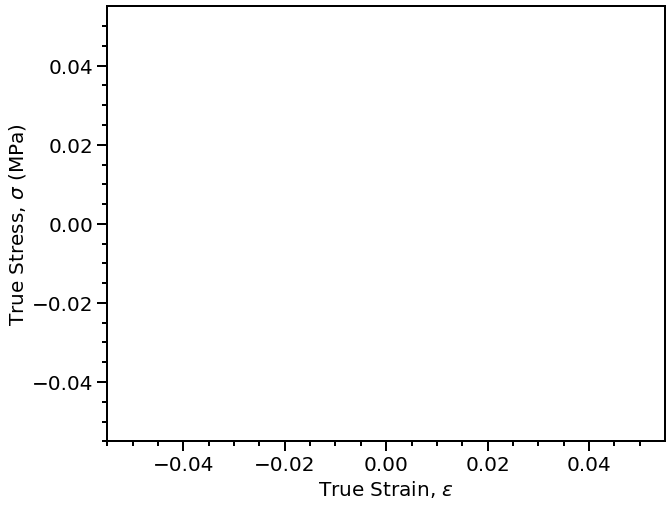

ETMT true stress-strain at SXRD frequency:


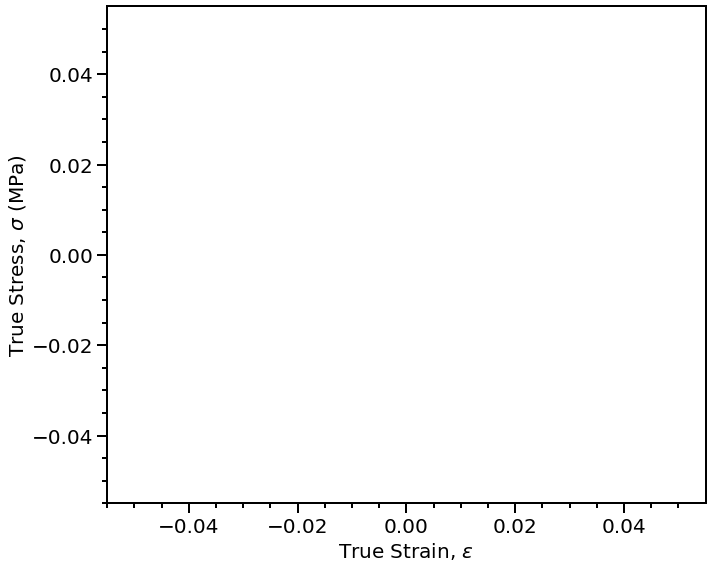

In [209]:
true_stress, true_strain = deformation.plot_thermomechanical_data(thermomechanical_equipment,thermomechanical_file_path, 
                                                            output_file_path, experiment_number,
                                                            minimum_stress, deform_sequence, 
                                                            number_of_frames, acquisition_frequency_sxrd, 
                                                            filter_equipment)

## Load the SXRD inputs

The additional information to analyse the synchrotron data can be loaded from the **second** yaml file using the command below.

Most importantly this defines the azimuthal angle for the loading direction.

In [210]:
beam_energy, azimuth_load_direction, filter_sxrd = sxrd.extract_sxrd_input(config_path_deformation)

The beam energy (in keV) is:
89.564

The load direction along the azimuthal angle (in degrees) is:
90

A median filter is being applied to the SXRD data, with a value of:
1



## Set the colour and marker scheme

The colour and marker scheme can be set automatically using the `colour_assign` and `marker_assign` functions. These are based on the number of lattice planes included in the analysis.

The current default for the alpha colour type is *viridis*.

The current default for the beta colour type is *PuRd*.

In [211]:
plane_colour = sxrd.colour_assign(peak_label)
plane_marker = sxrd.marker_assign(peak_label)

Plane colours have been defined for  16  lattice planes.

Plane markers have been defined for  16  lattice planes.



This line can be used to reduce the peak labels to plot just the important peaks.

*Note, the beta 211 peak may or may not be resolved, as it is often obscured by the adjacent alpha 10-13 peak.*

In [212]:
peak_label_reduced = ['10-10','0002','10-11','11-20','110','200','220']

## Check the start of deformation

### Option 1 - Lattice microstrain

The first option is to look for the characteristic change in lattice microstrain, by alterning the relative start and end points.

**After you have found the correct start and end numbers, add these values to the `start_deformation` and `end_deformation` parameters in the second deformation yaml file, save the yaml file, then re-start the notebook from the top and re-run all of the cells.**

In [213]:
# start_number = 10
# end_number = 2386

# sxrd.find_start_end_microstrain(start_number, end_number, image_numbers_sorted, peak_position_time,
#                                 peak_label_reduced, azimuth_load_direction, plane_colour, plane_marker)

### Option 2 - Synchronised thermomechanical analogue output

The second option is to look for the characteristic change in load response recorded by the thermomechanical equipment, by alterning the relative start and end points.

This is only possible if an anologue output from the thermomechanical equipment has already been synchronised with the synchrotron diffraction pattern images. This means a file exists that lists some of the thermomechanical deformation conditions (typically position, temperature and load), along with the corresponding image number. This is usually only possible with ETMT data recorded at Diamond Light Source.

To load the analogue data we need some additional information from the **second** yaml file.

In [214]:
# analogue_data_file_path, \
# load_conversion, temperature_conversion, position_conversion = deformation.extract_analogue_input(config_path_deformation)

Then, alternate the relative start and end points to look for the characteristic change in load response recorded by the termomechanical equipment.

**After you have found the correct start and end numbers, add these values to the `start_deformation` and `end_deformation` parameters in the second deformation yaml file, save the yaml file, then re-start the notebook from the top and re-run all of the cells.**

In [215]:
# start_number = 2059
# end_number = 2553

# deformation.plot_analogue_data(analogue_data_file_path, start_number, end_number, 
#                                load_conversion, temp_conversion, position_conversion)

## Analysing the peak changes

### Azimuthal peak position

Check how the minimum and maximum position of the ring changes throughout the test. These plots can be a bit messy as for uniaxial loading conditions the maxmimum and minimum positions of the peaks will alternate at ${180^\circ}$. However, they are useful to check that the the diffraction pattern ring asymmetry, and the individual positions of the peaks, are moving in a way that you'd expect given the loading conditions.

The start image number is  20 , which is the 19 index in the image number list.

The end image number is  2571 , which is the 2570 index in the image number list.

Variation of azimuthal angle of the MAXIMUM and MINIMUM position of the ring:


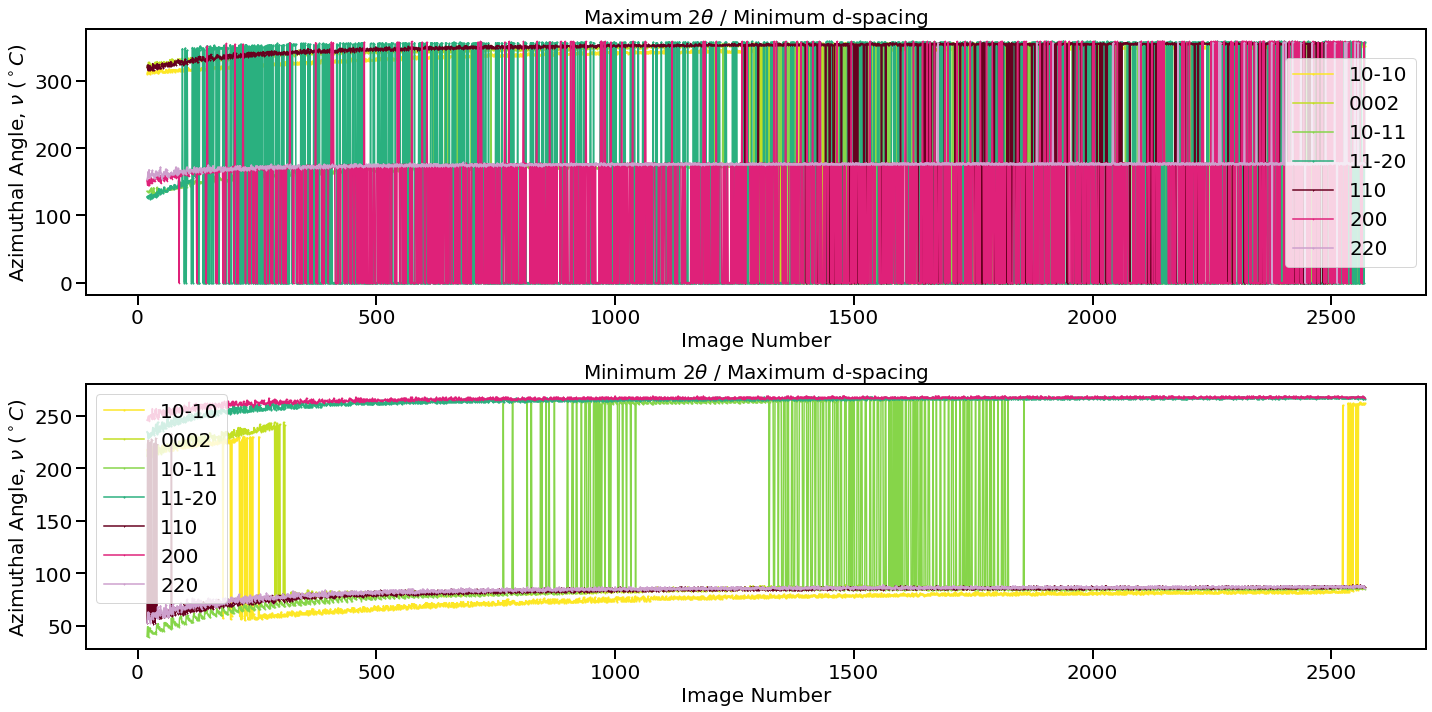

In [216]:
sxrd.follow_azimuth_angle(peak_position_time, image_numbers_sorted,
                          start_deformation, end_deformation,
                          peak_label_reduced, data_resolution, 
                          plane_colour, plane_marker, 
                          output_file_path, experiment_number)

### Lattice microstrain behaviour

The thermomechanical test results can then be combined with the elastic lattice strain response measured from the synchrotron diffraction patterns. This shows us the relative strength of the different phases and different grain orientations with respect to the loading direction.

- **"Soft" grain orientations** - reach an elastic lattice strain limit with greater applied stress, and therefore can be assumed to have begun plastically deforming at a lower stress.

- **"Hard" grain orientations** - continue to take up greater elastic lattice strain with greater applied stress, these reach there elastic strain limit later, at higher stresses.

The `plot_microstrain_stress` function includes additional inputs defined below. 

The `number_of_points` provides a cut off to remove measurements after yield, which can obscure the elastic-plastic transition. 

The microstrain, true stress and true strain limits can be used to set the plot limits for comparison with other data sets.

In [217]:
# alter this value to cut off any additional data, such as after plastic yield
number_of_points_stress = 3000
number_of_points_strain = 0

# set these values to zero if you do not want microstrain or true stress limits applied to the data
microstrain_limit = 0
true_stress_limit = 0
true_strain_limit = 0

The start image number is  20 , which is the 19 index in the image number list.

The end image number is  2571 , which is the 2570 index in the image number list.

Lattice microstrain variation with applied true stress for four different orthogonal directions:
0.027337092073987185
0.02731963878146724
0.027317893452215244
0.0273318560862312
0.02964878066825367
0.029623473394099757
0.029622600729473758
0.029631327375733728
0.031082568648767014
0.031079077990263024
0.03108431397801901
0.03107995065488902
0.047348164612728165
0.04734729194810217
0.047343801289598184
0.04733245664946022
0.030398399581985237
0.030382691618717286
0.030389672935725268
0.03038880027109927
0.04299095013512433
0.04297786016573436
0.04299095013512433
0.042965642860970404
0.060781963865328525
0.06076538323743457
0.06080290781635246
0.060779345871450535


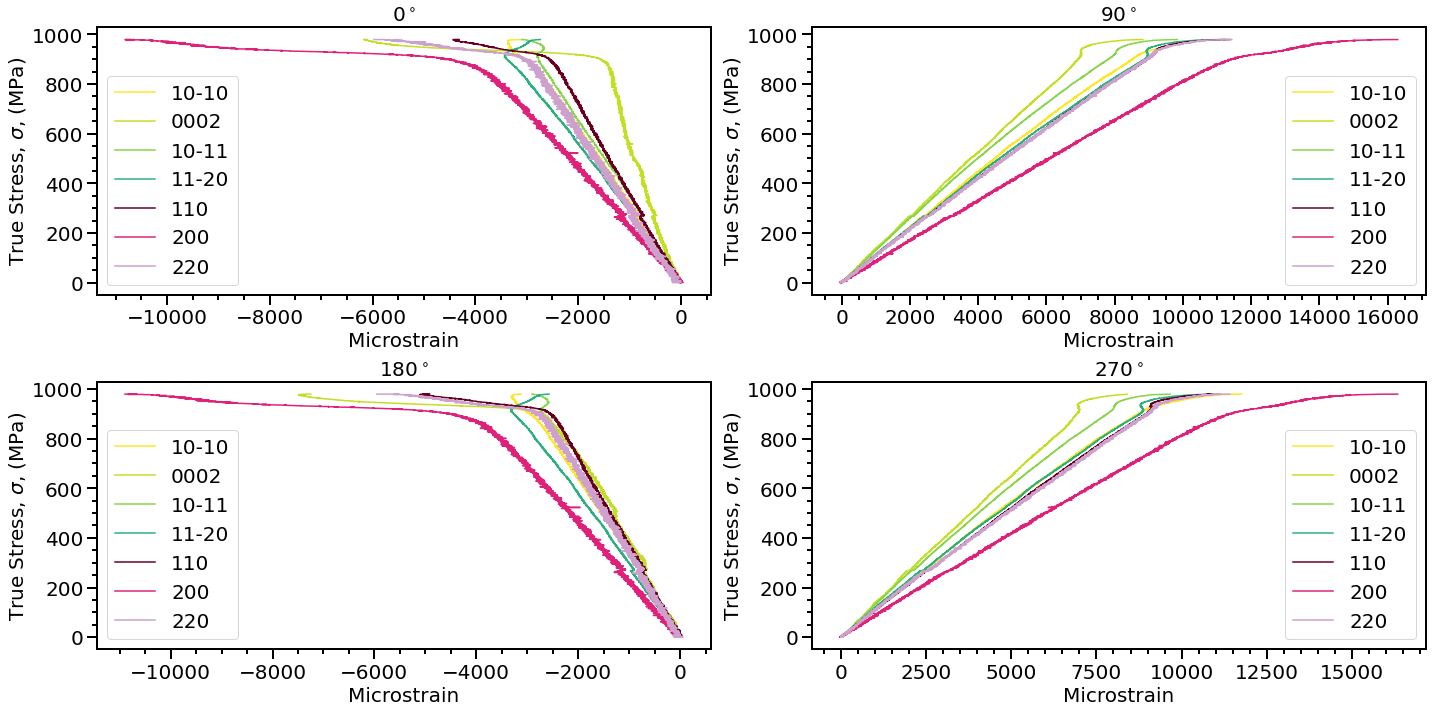

Lattice microstrain variation with applied true stress in chosen loading direction, defined at an azimuthal angle of '90' degrees:

0.02731963878146724
0.029623473394099757
0.031079077990263024
0.04734729194810217
0.030382691618717286
0.04297786016573436
0.06076538323743457


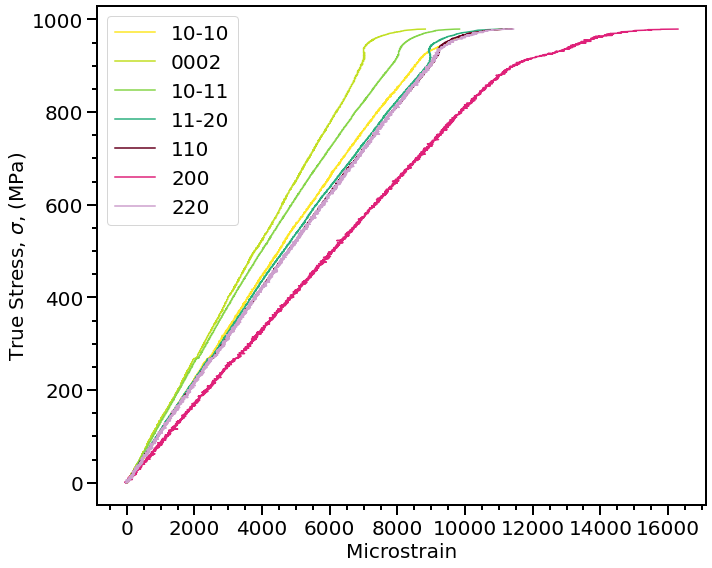

The lattice microstrain for '7' peaks has been saved to a .txt file: '../../../SXRD_results/diamond_2022/experiment_022/fourier-peak-analysis-deformation/microstrain_true_stress_load_direction_22.txt'.


In [218]:
sxrd.plot_microstrain_stress(start_deformation, end_deformation, image_numbers_sorted,
                             peak_position_time, true_stress, 
                             peak_label_reduced, azimuth_load_direction, plane_marker, plane_colour, 
                             output_file_path, experiment_number, filter_sxrd,
                             number_of_points_stress, microstrain_limit, true_stress_limit)

The plot of microstrain variation over time with applied strain, shows us the different loading states of the different two-phase grain types. For instance, load relaxation at high temperature might be showing us preferential recrystallization or phase transformation in the different grain types.

The start image number is  20 , which is the 19 index in the image number list.

The end image number is  2571 , which is the 2570 index in the image number list.

Lattice microstrain variation with applied true strain for four different orthogonal directions:
0.027337092073987185
0.02731963878146724
0.027317893452215244
0.0273318560862312
0.02964878066825367
0.029623473394099757
0.029622600729473758
0.029631327375733728
0.031082568648767014
0.031079077990263024
0.03108431397801901
0.03107995065488902
0.047348164612728165
0.04734729194810217
0.047343801289598184
0.04733245664946022
0.030398399581985237
0.030382691618717286
0.030389672935725268
0.03038880027109927
0.04299095013512433
0.04297786016573436
0.04299095013512433
0.042965642860970404
0.060781963865328525
0.06076538323743457
0.06080290781635246
0.060779345871450535


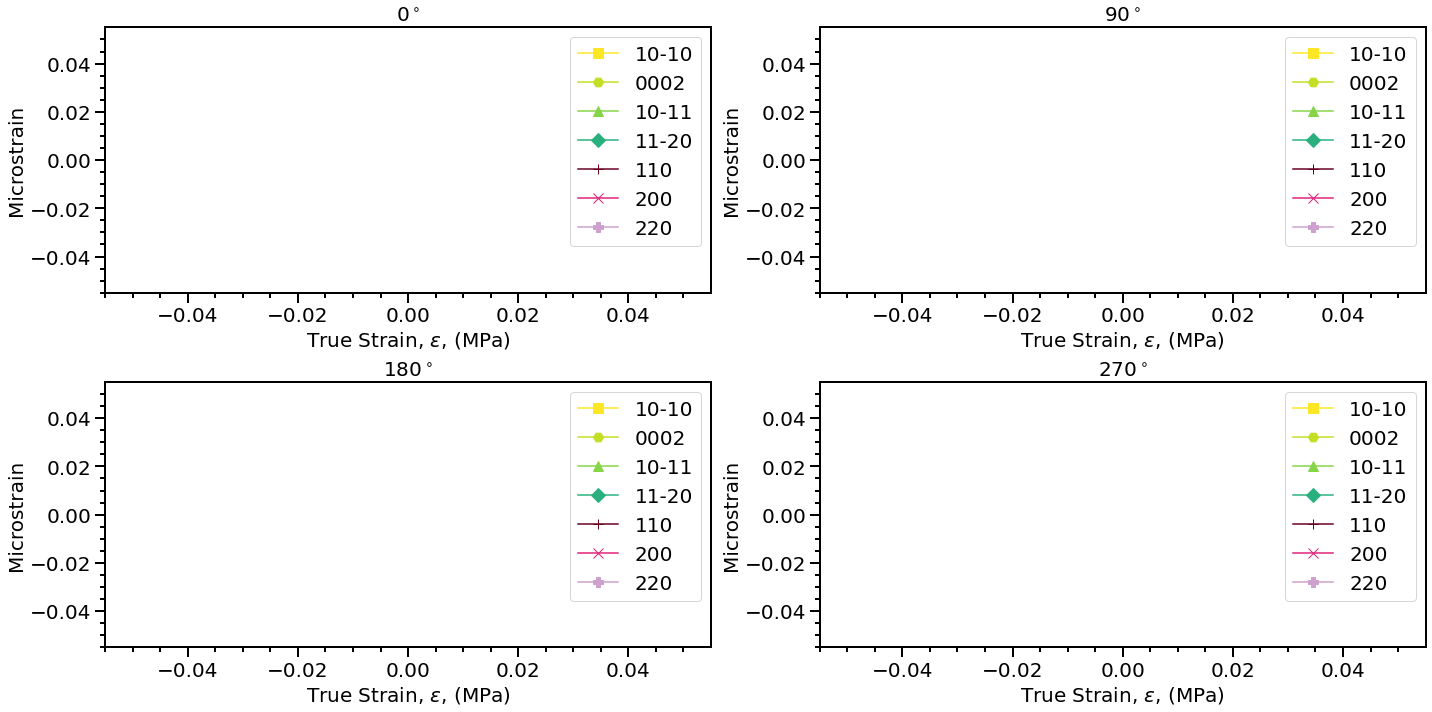

Lattice microstrain variation with applied true strain in chosen loading direction, defined at an azimuthal angle of '90' degrees:

0.02731963878146724
0.029623473394099757
0.031079077990263024
0.04734729194810217
0.030382691618717286
0.04297786016573436
0.06076538323743457


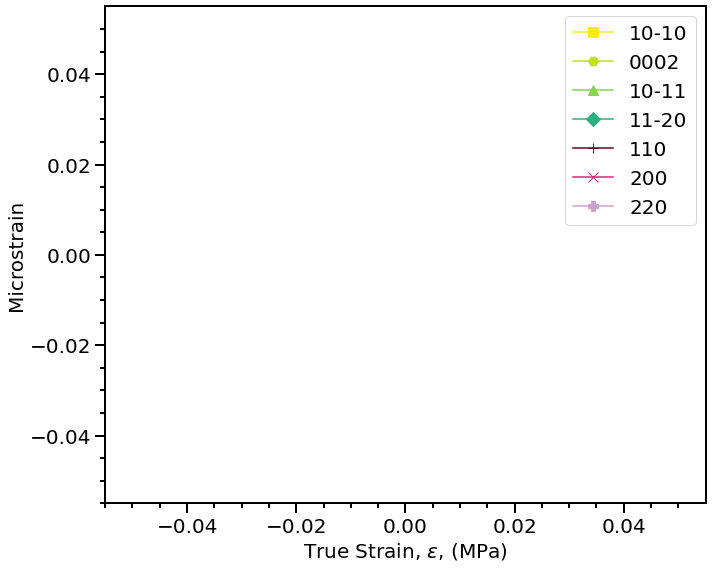

The lattice microstrain for '7' peaks has been saved to a .txt file: '../../../SXRD_results/diamond_2022/experiment_022/fourier-peak-analysis-deformation/true_strain_microstrain_load_direction_22.txt'.


In [219]:
sxrd.plot_microstrain_strain(start_deformation, end_deformation, image_numbers_sorted,
                             peak_position_time, true_strain, 
                             peak_label_reduced, azimuth_load_direction, plane_marker, plane_colour, 
                             output_file_path, experiment_number, filter_sxrd,
                             number_of_points_strain, microstrain_limit, true_strain_limit)

The start image number is  20 , which is the 19 index in the image number list.

The end image number is  2571 , which is the 2570 index in the image number list.

Lattice microstrain variation with applied true stress for four different orthogonal directions:
0.027337092073987185
0.02731963878146724
0.027317893452215244
0.0273318560862312
0.02964878066825367
0.029623473394099757
0.029622600729473758
0.029631327375733728
0.031082568648767014
0.031079077990263024
0.03108431397801901
0.03107995065488902
0.047348164612728165
0.04734729194810217
0.047343801289598184
0.04733245664946022
0.030398399581985237
0.030382691618717286
0.030389672935725268
0.03038880027109927
0.04299095013512433
0.04297786016573436
0.04299095013512433
0.042965642860970404
0.060781963865328525
0.06076538323743457
0.06080290781635246
0.060779345871450535


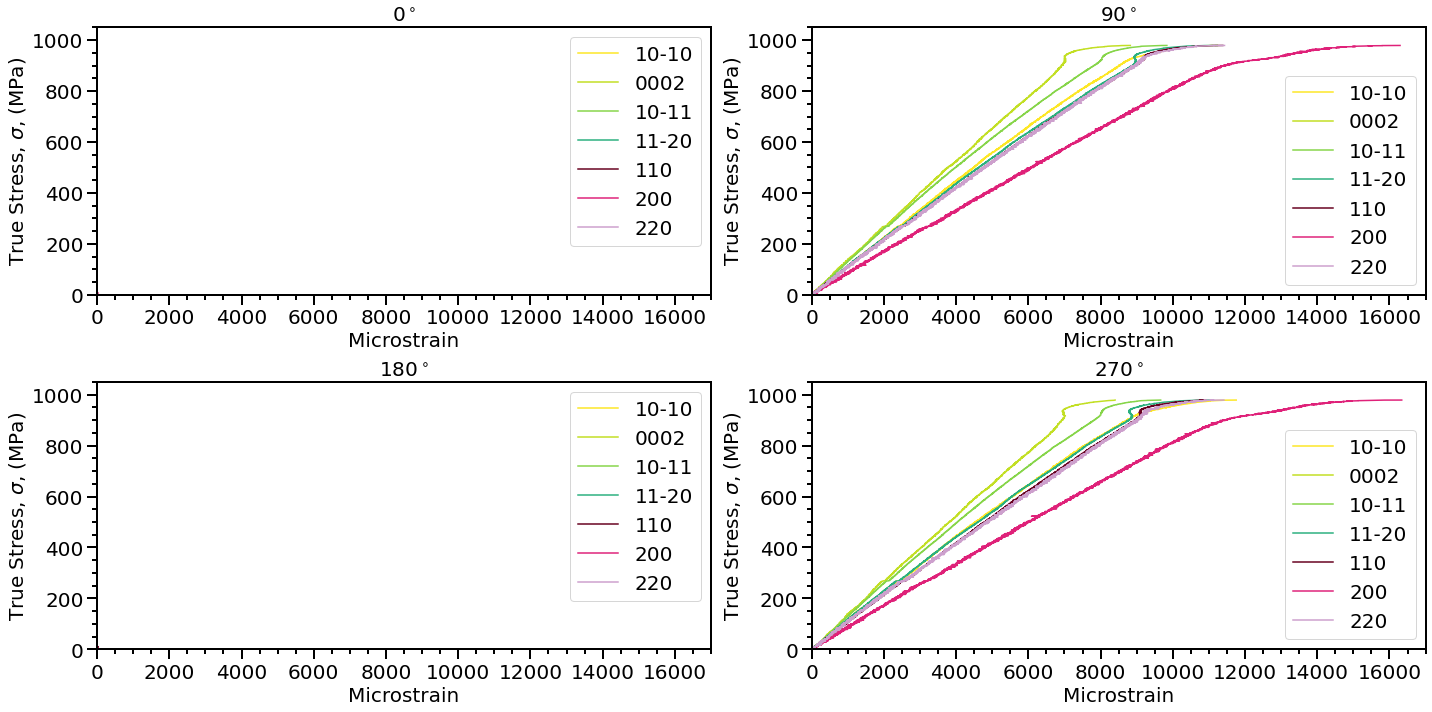

Lattice microstrain variation with applied true stress in chosen loading direction, defined at an azimuthal angle of '90' degrees:

0.02731963878146724
0.029623473394099757
0.031079077990263024
0.04734729194810217
0.030382691618717286
0.04297786016573436
0.06076538323743457


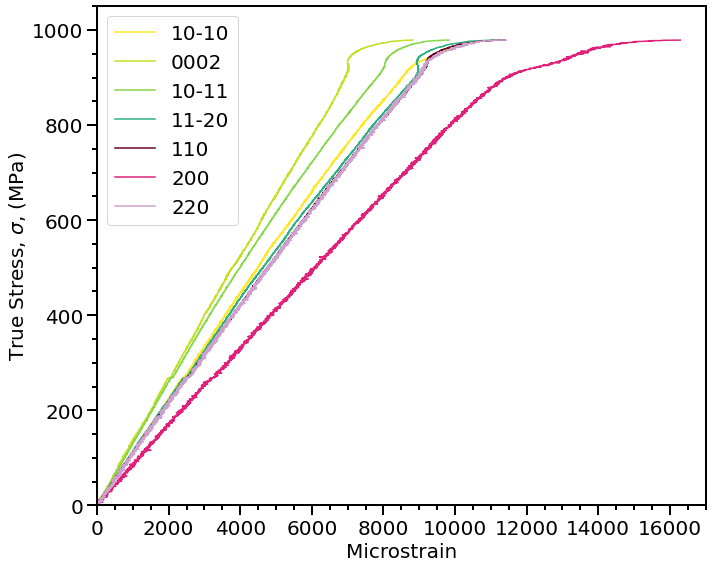

The lattice microstrain for '7' peaks has been saved to a .txt file: '../../../SXRD_results/diamond_2022/experiment_022/fourier-peak-analysis-deformation/microstrain_true_stress_load_direction_22.txt'.
The start image number is  20 , which is the 19 index in the image number list.

The end image number is  2571 , which is the 2570 index in the image number list.

Lattice microstrain variation with applied true strain for four different orthogonal directions:
0.027337092073987185
0.02731963878146724
0.027317893452215244
0.0273318560862312
0.02964878066825367
0.029623473394099757
0.029622600729473758
0.029631327375733728
0.031082568648767014
0.031079077990263024
0.03108431397801901
0.03107995065488902
0.047348164612728165
0.04734729194810217
0.047343801289598184
0.04733245664946022
0.030398399581985237
0.030382691618717286
0.030389672935725268
0.03038880027109927
0.04299095013512433
0.04297786016573436
0.04299095013512433
0.042965642860970404
0.060781963865328525
0.06076538323743457
0.06

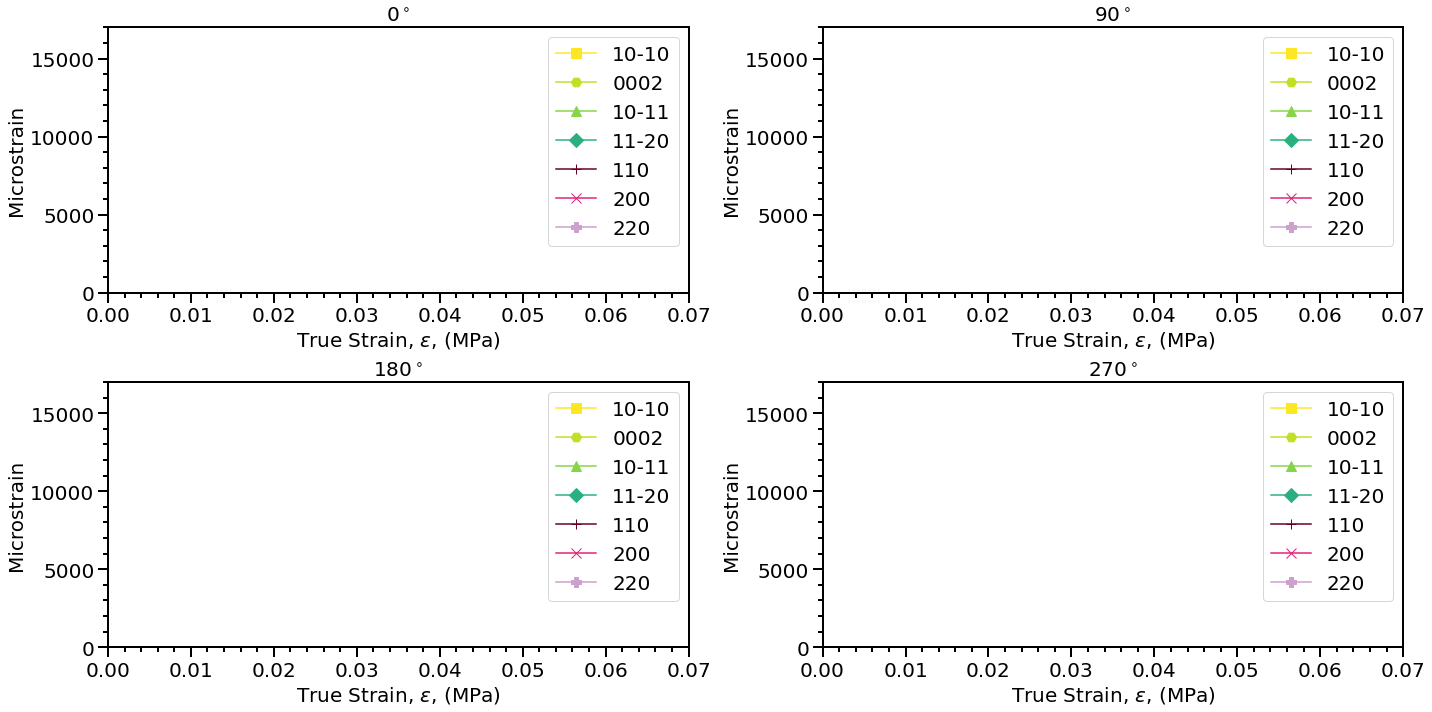

Lattice microstrain variation with applied true strain in chosen loading direction, defined at an azimuthal angle of '90' degrees:

0.02731963878146724
0.029623473394099757
0.031079077990263024
0.04734729194810217
0.030382691618717286
0.04297786016573436
0.06076538323743457


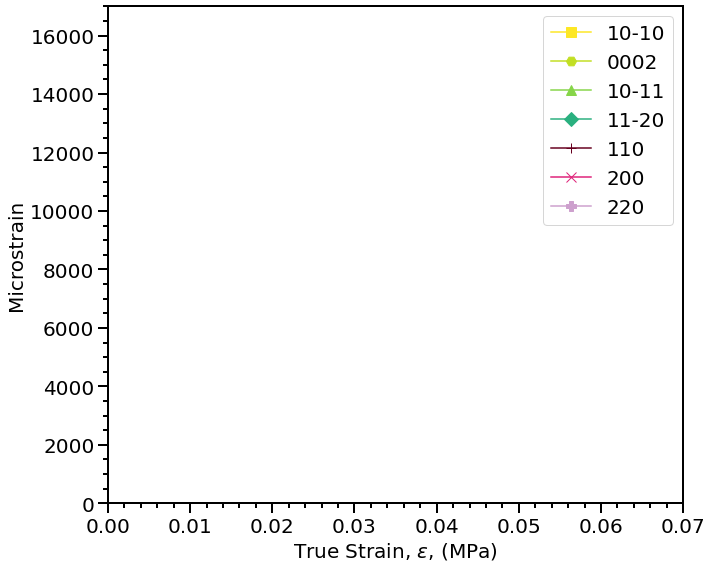

The lattice microstrain for '7' peaks has been saved to a .txt file: '../../../SXRD_results/diamond_2022/experiment_022/fourier-peak-analysis-deformation/true_strain_microstrain_load_direction_22.txt'.


In [220]:
microstrain_limit = 17000
true_stress_limit = 1050
true_strain_limit = 0.07

sxrd.plot_microstrain_stress(start_deformation, end_deformation, image_numbers_sorted,
                             peak_position_time, true_stress, 
                             peak_label_reduced, azimuth_load_direction, plane_marker, plane_colour, 
                             output_file_path, experiment_number, filter_sxrd,
                             number_of_points_stress, microstrain_limit, true_stress_limit)

sxrd.plot_microstrain_strain(start_deformation, end_deformation, image_numbers_sorted,
                             peak_position_time, true_strain, 
                             peak_label_reduced, azimuth_load_direction, plane_marker, plane_colour, 
                             output_file_path, experiment_number, filter_sxrd,
                             number_of_points_strain, microstrain_limit, true_strain_limit)

### Peak intensity behaviour [TODO]

### Polar plot of lattice microstrain behaviour [TODO]